In [4]:
# import libraries and packages needed
import os
import datetime

import numpy as np
import pandas

import matplotlib as mpl
import matplotlib.pyplot as plt

import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima

from sklearn.metrics import mean_squared_error

In [24]:
# Plot settings
mpl.rcParams["legend.fontsize"] = 14
mpl.rcParams["figure.titlesize"] = 20
mpl.rcParams["axes.titlesize"] = 18
mpl.rcParams["lines.linewidth"] = 1.5
mpl.rcParams["axes.labelsize"] = 16
mpl.rcParams["xtick.labelsize"] = 14
mpl.rcParams["ytick.labelsize"] = 14

plt.rcParams["figure.figsize"] = (6.4, 4.8)
plt.rcParams["font.family"] = "Times New Roman"

In [6]:
# Import wind production data for September 2023
data = pandas.read_csv("./Data/Windparks_September2023.csv", sep=";", index_col=1)
data.index = pandas.to_datetime(data.index, format="mixed", dayfirst=True)
data.head(5)

,UTC,Wind parks production,Wind parks production forecast - BRPs,Wind parks production forecast - system operator
Period,,,,
2023-09-01 01:00:00,1693519200,"9,1",5,"11,601"
2023-09-01 02:00:00,1693522800,"10,5",12,"8,889"
2023-09-01 03:00:00,1693526400,"17,4","11,1","11,357"
2023-09-01 04:00:00,1693530000,"19,3","13,8","11,187"
2023-09-01 05:00:00,1693533600,"29,8","13,6","14,251"


In [7]:
# Change the data format to float
wp_prod = data["Wind parks production"].str.replace(",", ".")
wp_prod = wp_prod.astype("float")
wp_forecast_brp = data["Wind parks production forecast - BRPs"].str.replace(",", ".")
wp_forecast_brp = wp_forecast_brp.astype("float")

print(wp_prod.head(5))
print(wp_forecast_brp.head(5))

Period
2023-09-01 01:00:00     9.1
2023-09-01 02:00:00    10.5
2023-09-01 03:00:00    17.4
2023-09-01 04:00:00    19.3
2023-09-01 05:00:00    29.8
Name: Wind parks production, dtype: float64
Period
2023-09-01 01:00:00     5.0
2023-09-01 02:00:00    12.0
2023-09-01 03:00:00    11.1
2023-09-01 04:00:00    13.8
2023-09-01 05:00:00    13.6
Name: Wind parks production forecast - BRPs, dtype: float64


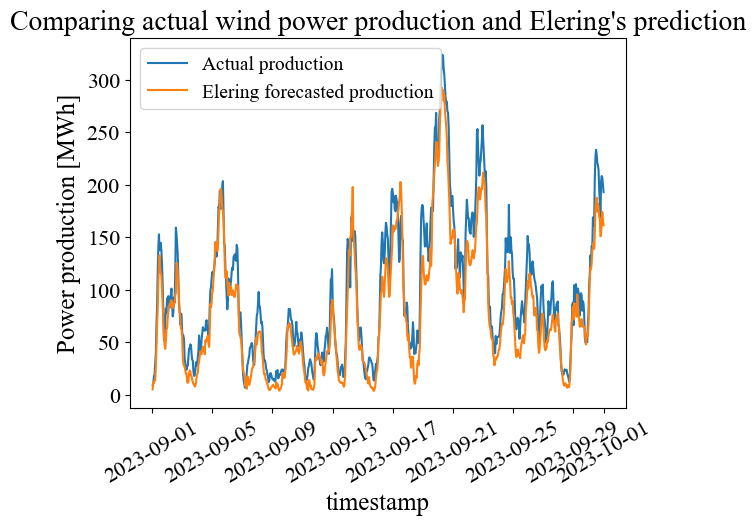

In [17]:
# Plot the actual & forecasted production data
fig1 = plt.figure(figsize=(6.4, 4.8))
plt.plot(data.index, wp_prod, label="Actual production")
plt.plot(data.index, wp_forecast_brp, label="Elering forecasted production")
plt.title("Comparing actual wind power production and Elering's prediction", fontsize=20)
plt.xlabel("timestamp", fontsize=18)
plt.xticks(rotation=30, fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel("Power production [MWh]", fontsize=18)
plt.legend(loc="best")
plt.gcf().savefig("./Data/Figure1.png", bbox_inches="tight")

plt.show()

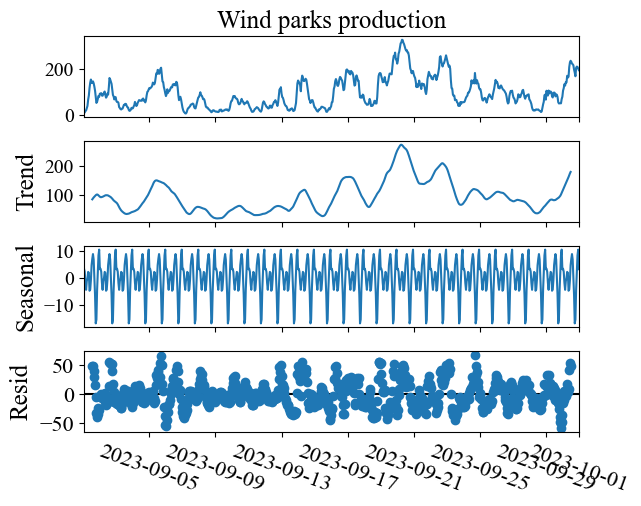

In [29]:
# Decompose seasonal componenet
mpl.rcParams["axes.labelsize"] = 18

decompose_result = seasonal_decompose(wp_prod)
fig2 = decompose_result.plot()
plt.xticks(rotation=-20, fontsize=16);
plt.yticks(fontsize=16);
plt.gcf().savefig("./Data/Figure2.png", bbox_inches="tight")
# The wind production shows seasonal peridocitity on a daily basis

<Figure size 800x600 with 0 Axes>

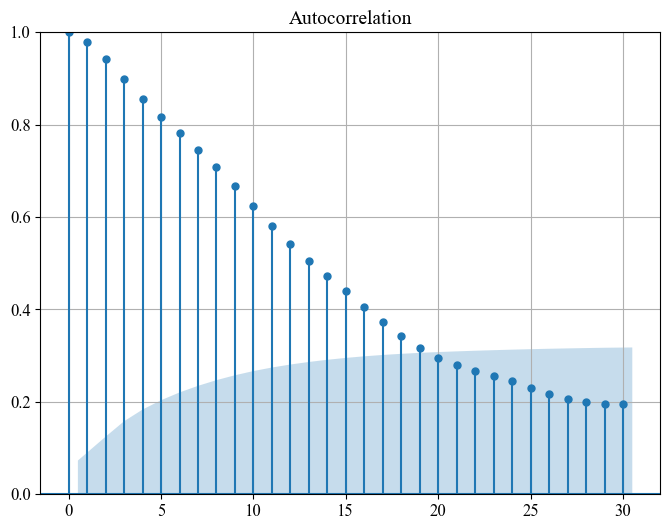

In [23]:
# Plot the autocorrelation plot to check stationarity
_fig = plt.figure()
statsmodels.graphics.tsaplots.plot_acf(wp_prod.values, lags=30)
plt.grid(True)
plt.ylim([0.0, 1.0]);
# Autocorrelation plot does not show exponential decrease, rather decreasing slowly.

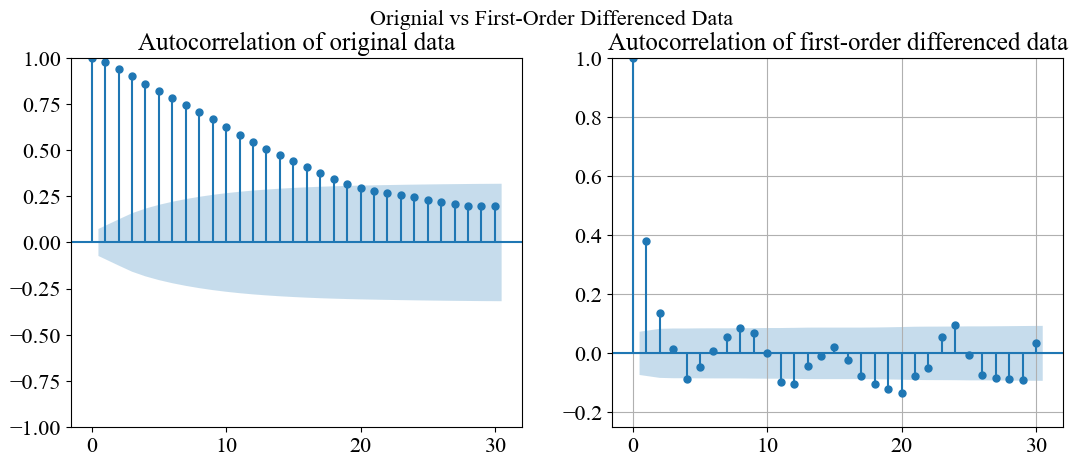

In [38]:
# Apply first order differencing to obtain stationarity of the data
wp_prod_diff = wp_prod.copy()
wp_prod_diff = wp_prod_diff.diff()
wp_prod_diff = wp_prod_diff.dropna()

fig3, ax = plt.subplots(1, 2, figsize=(12.8, 4.8))
fig3.suptitle("Orignial vs First-Order Differenced Data", fontsize=16)
statsmodels.graphics.tsaplots.plot_acf(wp_prod, lags=30, ax=ax[0])
statsmodels.graphics.tsaplots.plot_acf(wp_prod_diff, lags=30, ax=ax[1])
ax[0].set_title("Autocorrelation of original data", fontsize=18)
ax[1].set_title("Autocorrelation of first-order differenced data", fontsize=18)
mpl.rcParams["xtick.labelsize"] = 16
mpl.rcParams["ytick.labelsize"] = 16
plt.grid(True)
plt.ylim([-0.25, 1.0])
fig3.savefig("./Data/Figure3.png", bbox_inches="tight")

# The 1st order differenced data now shows exponential decline in autocorrelation,
# implying the data is stationary.

In [25]:
# Search for the optimal orders of the SARIMAX model
# Use the autoarima package

model_autoarima = auto_arima(
    wp_prod,
    start_p=1, d=1, start_q=1,
    max_p=5, max_d=1, max_q=5,
    start_P=1, D=1, start_Q=1,
    max_P=3, max_D=2, max_Q=3,
    m=24, max_order=None,
    seasonal=True, stationary=False,
    information_criterion="aic",
    alpha=0.05,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True,
    n_jobs=-1,
    trend="t",
    maxiter=20
)

print(f"best aic: {model_autoarima.aic()}")

/Users/parkhyuntae/opt/anaconda3/envs/enereng2023/lib/python3.8/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[24]             : AIC=5542.197, Time=5.47 sec
 ARIMA(0,1,0)(0,1,0)[24]             : AIC=5916.300, Time=0.23 sec
 ARIMA(1,1,0)(1,1,0)[24]             : AIC=5636.257, Time=4.51 sec
 ARIMA(0,1,1)(0,1,1)[24]             : AIC=inf, Time=4.12 sec
 ARIMA(1,1,1)(0,1,1)[24]             : AIC=5537.354, Time=2.34 sec
 ARIMA(1,1,1)(0,1,0)[24]             : AIC=5802.827, Time=1.16 sec
 ARIMA(1,1,1)(0,1,2)[24]             : AIC=inf, Time=13.95 sec
 ARIMA(1,1,1)(1,1,0)[24]             : AIC=5655.157, Time=4.86 sec
 ARIMA(1,1,1)(1,1,2)[24]             : AIC=inf, Time=18.32 sec
 ARIMA(1,1,0)(0,1,1)[24]             : AIC=inf, Time=4.39 sec
 ARIMA(2,1,1)(0,1,1)[24]             : AIC=inf, Time=6.15 sec
 ARIMA(1,1,2)(0,1,1)[24]             : AIC=inf, Time=6.58 sec
 ARIMA(0,1,0)(0,1,1)[24]             : AIC=inf, Time=3.90 sec
 ARIMA(0,1,2)(0,1,1)[24]             : AIC=inf, Time=5.73 sec
 ARIMA(2,1,0)(0,1,1)[24]             : AIC=inf, Time=5.30

In [26]:
# See model summary
model_autoarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  720
Model:             SARIMAX(2, 1, 2)x(0, 1, [1], 24)   Log Likelihood               -2760.316
Date:                              Sun, 22 Oct 2023   AIC                           5534.633
Time:                                      18:47:35   BIC                           5566.440
Sample:                                  09-01-2023   HQIC                          5546.932
                                       - 10-01-2023                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0001      0.001      0.185      0.853      -0.001       0.001
ar.L1          0.1714      4.251      0.040      0.968      -8.161       8.504
ar.L2          0.0401      1.612      0.025      0.980      -3.119       3.199
ma.L1          0.1944      4.242      0.046      0.963      -8.120       8.508
ma.L2          0.0354      0.172      0.206      0.837      -0.302       0.373
ma.S.L24      -0.7853      0.058    -13.630      0.000      -0.898      -0.672
sigma2       240.8796     15.244     15.802      0.000     211.002     270.757
===================================================================================
Ljung-Box (L1) (Q):                   0.30   Jarque-Bera (JB):               203.00
Prob(Q):                              0.58   Prob(JB):                         0.00
Heteroskedasticity (H):               2.06   Skew:                             0.44
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [27]:
# Get the optimal orders obtained by autoarima
params = model_autoarima.get_params()
order = params["order"]
seasonal_order = params["seasonal_order"]

In [41]:
# Fit the model by the optimal orders
# model_opti = SARIMAX(wp_prod, order=order, seasonal_order=seasonal_order)
model_opti = SARIMAX(wp_prod, order=(2, 1, 2), seasonal_order=(0, 1, 1, 24))
model_opti_fit = model_opti.fit(disp=False)

/Users/parkhyuntae/miniconda3/envs/enereng2023/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/parkhyuntae/miniconda3/envs/enereng2023/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/parkhyuntae/miniconda3/envs/enereng2023/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/parkhyuntae/miniconda3/envs/enereng2023/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting

In [42]:
# Load the test data
data_test = pandas.read_csv("./Data/Windparks_October01.csv", sep=";", index_col=1)
data_test.index = pandas.to_datetime(data_test.index, format="mixed", dayfirst=True)
wp_prod_test = data_test["Wind parks production"].str.replace(",", ".")
wp_prod_test = wp_prod_test.astype("float")
wp_forecast_brp_test = data_test["Wind parks production forecast - BRPs"].str.replace(",", ".")
wp_forecast_brp_test = wp_forecast_brp_test.astype("float")

In [43]:
# Predict using the optimal SARIMAX model
wp_forecast_arima = model_opti_fit.predict(wp_prod_test.index[0],
                                               wp_prod_test.index[-1])


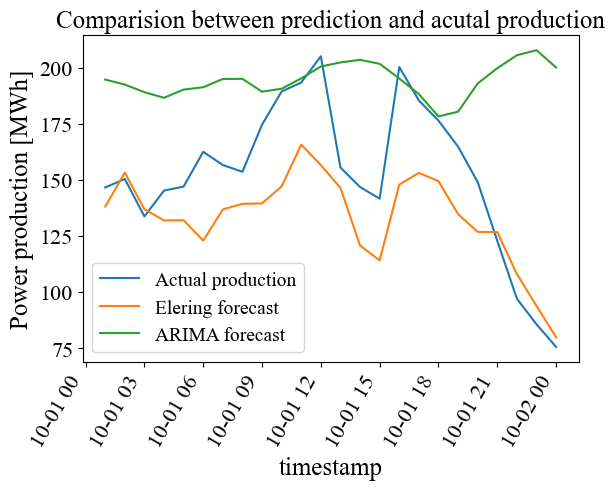

In [44]:
# Plot the prediction results.
fig4 = plt.figure(figsize=(6.4, 4.8))
plt.plot(data_test.index, wp_prod_test, label="Actual production")
plt.plot(data_test.index, wp_forecast_brp_test, label="Elering forecast")
wp_forecast_arima.plot(label="ARIMA forecast")
# plt.plot(data_test.index, wp_forecast_arima[:, 1], label="ARIMA predicted production")
plt.title("Comparision between prediction and acutal production")
plt.xlabel("timestamp")
plt.xticks(rotation=60)
plt.ylabel("Power production [MWh]")
plt.legend(loc="best")
# fig4.savefig("./Data/Figure4.png")
plt.show()

In [32]:
# Evaluate the prediction by RMSE value.
RMSE_ELERING = np.sqrt(mean_squared_error(wp_prod_test, wp_forecast_brp_test))
RMSE_ARIMA = np.sqrt(mean_squared_error(wp_prod_test, wp_forecast_arima))
print(f"RMSE of Elering forecast >> ({RMSE_ELERING})")
print(f"RMSE of ARIMA forecast >> ({RMSE_ARIMA})")

RMSE of Elering forecast >> (26.185921790152815)
RMSE of ARIMA forecast >> (55.6849626589921)
